# Creating a Knowledge Graph using an LLM

# Installing the dependencies

In [1]:
!pip install "mirascope[openai]" matplotlib networkx beautifulsoup4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.2/373.2 kB 7.5 MB/s eta 0:00:00


## OpenAI API Key
To get an OpenAI API key, visit https://platform.openai.com/settings/organization/api-keys and generate a new key. If you're a new user, you may need to add billing details and make a minimum payment of $5 to activate API access.

In [1]:
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass('Enter OpenAI API Key: ')

Enter OpenAI API Key: ··········


# Defining Graph Schema

In [8]:
from pydantic import BaseModel, Field

class Edge(BaseModel):
    source: str
    target: str
    relationship: str

class Node(BaseModel):
    id: str
    type: str
    properties: dict | None = None

class KnowledgeGraph(BaseModel):
    nodes: list[Node]
    edges: list[Edge]


# Defining the Patient Log

In [15]:
patient_log = """
Mary called for help at 3:45 AM, reporting that she had fallen while going to the bathroom. This marks the second fall incident within a week. She complained of dizziness before the fall.

Earlier in the day, Mary was observed wandering the hallway and appeared confused when asked basic questions. She was unable to recall the names of her medications and asked the same question multiple times.

Mary skipped both lunch and dinner, stating she didn’t feel hungry. When the nurse checked her room in the evening, Mary was lying in bed with mild bruising on her left arm and complained of hip pain.

Vital signs taken at 9:00 PM showed slightly elevated blood pressure and a low-grade fever (99.8°F). Nurse also noted increased forgetfulness and possible signs of dehydration.

This behavior is similar to previous episodes reported last month.
"""


# Generating the Knowledge Graph

In [10]:
from mirascope.core import openai, prompt_template

@openai.call(model="gpt-4o-mini", response_model=KnowledgeGraph)
@prompt_template(
    """
    SYSTEM:
    Extract a knowledge graph from this patient log.
    Use Nodes to represent people, symptoms, events, and observations.
    Use Edges to represent relationships like "has symptom", "reported", "noted", etc.

    The log:
    {log_text}

    Example:
    Mary said help, I've fallen.
    Node(id="Mary", type="Patient", properties={{}})
    Node(id="Fall Incident 1", type="Event", properties={{"time": "3:45 AM"}})
    Edge(source="Mary", target="Fall Incident 1", relationship="reported")
    """
)
def generate_kg(log_text: str) -> openai.OpenAIDynamicConfig:
    return {"log_text": log_text}


In [11]:
kg = generate_kg(patient_log)
print(kg)

nodes=[Node(id='Mary', type='Patient', properties={}), Node(id='Fall Incident 1', type='Event', properties={'time': '3:45 AM'}), Node(id='Disorientation', type='Symptom', properties={}), Node(id='Skipped Lunch', type='Event', properties={}), Node(id='Bruising', type='Observation', properties={'description': 'slight bruising on her arm'})] edges=[Edge(source='Mary', target='Fall Incident 1', relationship='reported'), Edge(source='Mary', target='Disorientation', relationship='has symptom'), Edge(source='Mary', target='Skipped Lunch', relationship='reported'), Edge(source='Nurse', target='Bruising', relationship='noted'), Edge(source='Mary', target='Bruising', relationship='has observation')]


# Querying the graph

In [12]:
@openai.call(model="gpt-4o-mini")
@prompt_template(
    """
    SYSTEM:
    Use the knowledge graph to answer the user’s question.

    Graph:
    {knowledge_graph}

    USER:
    {question}
    """
)
def run(question: str, knowledge_graph: KnowledgeGraph): ...


In [16]:
question = "What health risks or concerns does Mary exhibit based on her recent behavior and vitals?"
print(run(question, kg))

Based on the information provided, Mary exhibits several health risks and concerns:

1. **Fall Incident**: Mary reported a fall incident at 3:45 AM, which could indicate issues with balance, coordination, or possible underlying health conditions that need to be addressed.

2. **Disorientation**: She has reported experiencing disorientation. This symptom could be related to various health issues, including neurological concerns or medication side effects.

3. **Skipped Meals**: The report of skipping lunch could suggest a lack of appetite, possible cognitive issues, or neglecting self-care, which can lead to nutritional deficits.

4. **Bruising**: The observation of slight bruising on her arm indicates potential trauma from the fall incident or may signal other underlying issues such as blood clotting problems.

These factors combined may point to increased vulnerability and a need for further assessment and monitoring of her health and safety.


# Visualizing the Graph

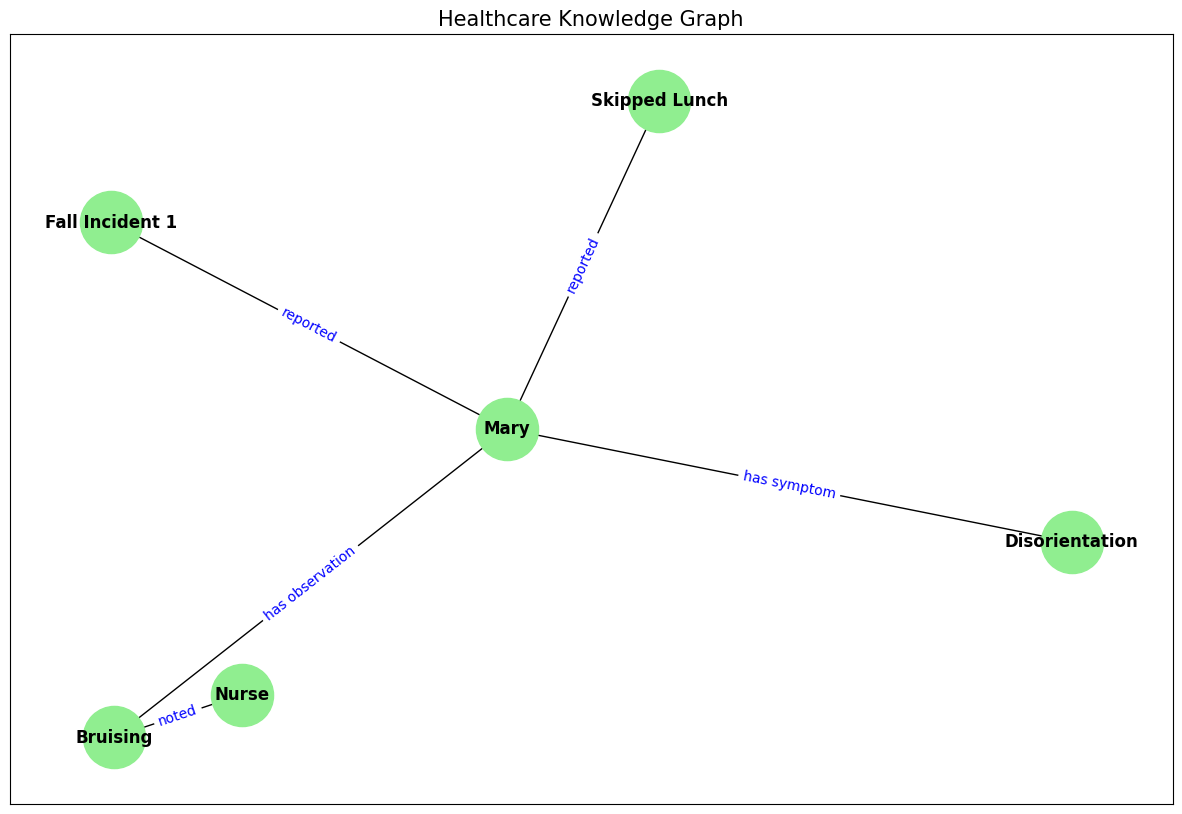

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

def render_graph(kg: KnowledgeGraph):
    G = nx.DiGraph()

    for node in kg.nodes:
        G.add_node(node.id, label=node.type, **(node.properties or {}))

    for edge in kg.edges:
        G.add_edge(edge.source, edge.target, label=edge.relationship)

    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightgreen")
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="blue")
    plt.title("Healthcare Knowledge Graph", fontsize=15)
    plt.show()

render_graph(kg)